# Investigating the proportion of NPs and synthetic in ClinicalTrials.gov

Data from https://aact.ctti-clinicaltrials.org

In [2]:
import json
import warnings
from collections import defaultdict

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib_venn import venn3
from np_likeness_utils import (
    calculate_percentage_nps_synthetics_hybrids,
    get_np_scores,
)
import seaborn as sns
from rdkit import RDLogger
from rdkit.Chem.PandasTools import LoadSDF

In [3]:
sns.set_style("whitegrid")

In [4]:
warnings.simplefilter(action="ignore", category=FutureWarning)
RDLogger.DisableLog("rdApp.*")

In [5]:
plt.rcParams["figure.dpi"] = 500

Read clinical trials data (downloaded from https://aact.ctti-clinicaltrials.org/download)

In [6]:
interventions_df = pd.read_csv(
    "../../data/clinical_trials/interventions.txt.gz",
    compression="gzip",
    sep="|",
    usecols=[
        "id",
        "nct_id",
        "intervention_type",
        "name",
    ],
)

In [7]:
interventions_df.head(1)

,id,nct_id,intervention_type,name
0,60225410,NCT05940870,Device,Nerivio


Load study metadata

In [8]:
studies_df = pd.read_csv(
    "../../data/clinical_trials/studies.txt.gz",
    sep="|",
    usecols=[
        "nct_id",
        "phase",
    ],
    index_col="nct_id",
    dtype="str",
    compression="gzip",
)

In [9]:
studies_df.shape[0]

467704

Mapping clinical trials ids to phase

In [10]:
studies_df = studies_df[studies_df["phase"] != "Not Applicable"]
# Remove NaNs in phase
studies_df = studies_df[studies_df["phase"].notna()]

In [11]:
studies_df.shape[0]

190074

Change the following line depending on the way you want to evaluate clinical trials with both phases simultaneously evaluated

E.g., phase 1/2 = phase 2 or phase 1/2 = phase 1

In [12]:
# studies_df["phase"] = studies_df["phase"].str.replace("Phase 1/Phase 2", "Phase 1")
# studies_df["phase"] = studies_df["phase"].str.replace("Phase 2/Phase 3", "Phase 2")

In [13]:
# Map nct_id (index) to phase witha dict
studies_df = studies_df["phase"].to_dict()

Subset all clinical trials to studies in at least phase I

In [14]:
interventions_df = interventions_df[interventions_df.nct_id.isin(studies_df.keys())]

Map each intervention name to its phase

In [15]:
# Map name to nct_id with a dict
intervention_to_latest_phase = defaultdict(set)

for _, nct_id, _, intervention_name in interventions_df.values:
    intervention_to_latest_phase[intervention_name].add(int(studies_df[nct_id][-1]))

In [16]:
len(intervention_to_latest_phase)

168634

Grounding intervention names to PubChem ids

In [17]:
# read json file from local folder (data)
with open("../../data/chemicals/drug_to_pubchems.json") as json_file:
    drug_to_pubchems = json.load(json_file)


with open("../../data/chemicals/skipped.json") as json_file:
    skipped_interventions = json.load(json_file)

# ensure that the entity is not grounded and that the entity is an study that is already in at least phase I
skipped_entities = [
    skipped_entity
    for skipped_entity in skipped_interventions
    if pd.notna(skipped_entity)
    and skipped_entity not in drug_to_pubchems
    and skipped_entity in intervention_to_latest_phase
]


# Mapping grounded interventions to their corresponding pubchems
drug_to_pubchems = {
    drug: pubchems
    for drug, pubchems in drug_to_pubchems.items()
    if drug in intervention_to_latest_phase
}

del skipped_interventions

Cache for NPClassifier

In [18]:
with open("../../data/chemicals/np_classifier_cache.json") as json_file:
    np_classifier_cache = json.load(json_file)

In [19]:
len(drug_to_pubchems), len(set(skipped_entities)), len(np_classifier_cache)

(56000, 54305, 28500)

Cache for NP-likeness, Lipinski and SAS score

In [20]:
np_likeness_cache = {}
sas_cache = {}
lipinski_cache = {}

# Collect NP Classifier info
skip_np_classifier = False

# Clinical trials

Stratifying by clinical trial phase

In [21]:
phase_1_smiles = {
    drug_dict["smiles"]
    for intervention_name, mapped_chemicals in drug_to_pubchems.items()
    for drug_dict in mapped_chemicals
    if 1 in intervention_to_latest_phase[intervention_name]
}

phase_2_smiles = {
    drug_dict["smiles"]
    for intervention_name, mapped_chemicals in drug_to_pubchems.items()
    for drug_dict in mapped_chemicals
    if 2 in intervention_to_latest_phase[intervention_name]
}

phase_3_smiles = {
    drug_dict["smiles"]
    for intervention_name, mapped_chemicals in drug_to_pubchems.items()
    for drug_dict in mapped_chemicals
    if 3 in intervention_to_latest_phase[intervention_name]
}

# these are already approved drugs
phase_4_smiles = {
    drug_dict["smiles"]
    for intervention_name, mapped_chemicals in drug_to_pubchems.items()
    for drug_dict in mapped_chemicals
    if 4 in intervention_to_latest_phase[intervention_name]
}

In [22]:
len(phase_1_smiles), len(phase_2_smiles), len(phase_3_smiles), len(phase_4_smiles)

(5173, 5491, 3778, 2625)

In case you want to change the assumptions (results dont change)

In [23]:
# # remove from phase i the ones that are in phase ii or iii
# phase_1_smiles = set(phase_1_smiles) - set(phase_2_smiles) - set(phase_3_smiles)

# # remove from phase ii the ones that are in phase iii
# phase_2_smiles = set(phase_2_smiles) - set(phase_3_smiles)

In [24]:
# len(phase_1_smiles), len(phase_2_smiles), len(phase_3_smiles)

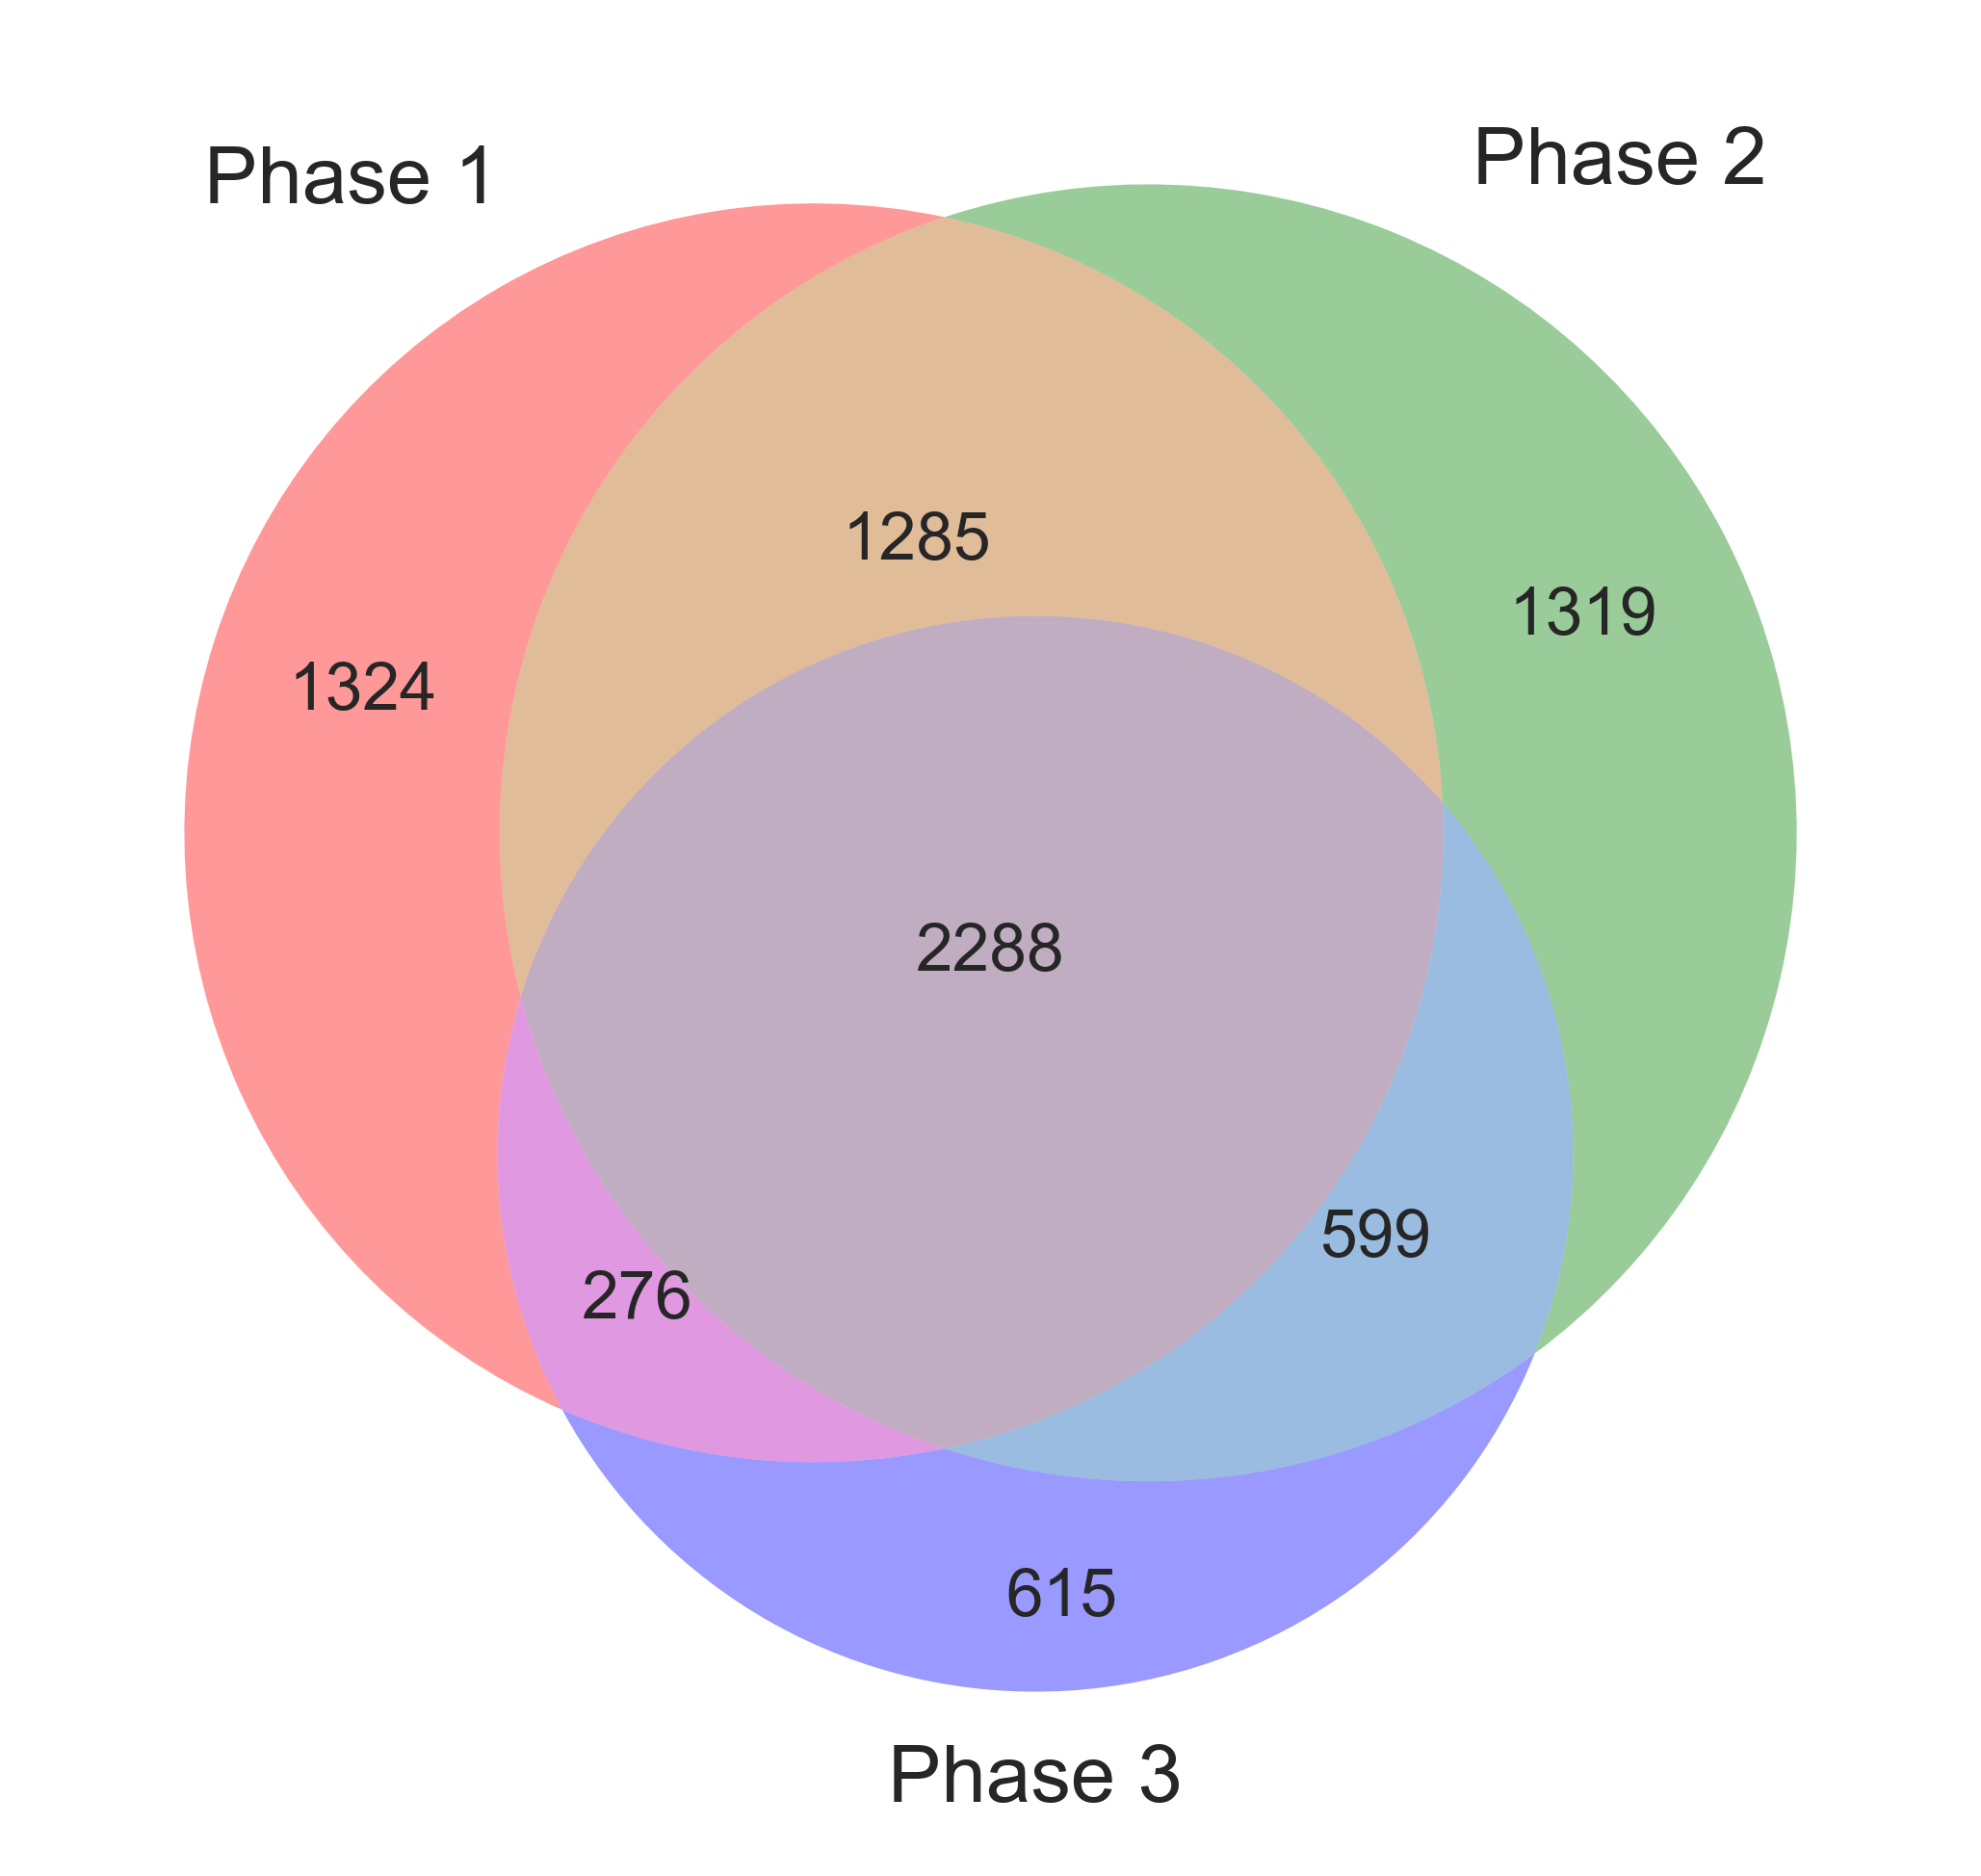

In [25]:
# Make a venn diagram with the inchikeys of the three phases
venn3(
    [set(phase_1_smiles), set(phase_2_smiles), set(phase_3_smiles)],
    set_labels=["Phase 1", "Phase 2", "Phase 3"],
)

plt.show()

In [26]:
phase_i_scores, phase_i_inchikeys, phase_i_np_classifier = get_np_scores(
    all_smiles=phase_1_smiles,
    np_likeness_cache=np_likeness_cache,
    sas_cache=sas_cache,
    lipinski_cache=lipinski_cache,
    skip_np_classifier=skip_np_classifier,
    np_classifier_cache=np_classifier_cache,
)

phase_i_dict = calculate_percentage_nps_synthetics_hybrids(
    phase_i_scores,
    dataset_name="Phase 1 drugs",
)

phase_ii_scores, phase_ii_inchikeys, phase_ii_np_classifier = get_np_scores(
    all_smiles=phase_2_smiles,
    np_likeness_cache=np_likeness_cache,
    sas_cache=sas_cache,
    lipinski_cache=lipinski_cache,
    skip_np_classifier=skip_np_classifier,
    np_classifier_cache=np_classifier_cache,
)

phase_ii_dict = calculate_percentage_nps_synthetics_hybrids(
    phase_ii_scores,
    dataset_name="Phase 2 drugs",
)

phase_iii_scores, phase_iii_inchikeys, phase_iii_np_classifier = get_np_scores(
    all_smiles=phase_3_smiles,
    np_likeness_cache=np_likeness_cache,
    sas_cache=sas_cache,
    lipinski_cache=lipinski_cache,
    skip_np_classifier=skip_np_classifier,
    np_classifier_cache=np_classifier_cache,
)

phase_iii_dict = calculate_percentage_nps_synthetics_hybrids(
    phase_iii_scores,
    dataset_name="Phase 3 drugs",
)

5173 smiles before removing duplicates


100%|██████████| 5173/5173 [00:00<00:00, 10489.37it/s]
reading NP model ...
model in


397 duplicates found 8.0% of the total)


100%|██████████| 4831/4831 [00:47<00:00, 102.29it/s]


0 smiles skipped for less than 4 atoms

            NP-likeness stats between duplicate pairs.

            Average: -0.002

            Median: 0.0008710278194576804

            Max: 1.181

            Min: -0.919

            Std: 0.165

            
5491 smiles before removing duplicates


100%|██████████| 5491/5491 [00:00<00:00, 11366.77it/s]
reading NP model ...
model in


448 duplicates found 8.0% of the total)


100%|██████████| 5116/5116 [00:34<00:00, 150.03it/s]


0 smiles skipped for less than 4 atoms

            NP-likeness stats between duplicate pairs.

            Average: 0.005

            Median: 0.0014835027198019587

            Max: 1.181

            Min: -1.028

            Std: 0.161

            
3778 smiles before removing duplicates


100%|██████████| 3778/3778 [00:00<00:00, 16193.66it/s]
reading NP model ...
model in


422 duplicates found 11.0% of the total)


100%|██████████| 3433/3433 [00:12<00:00, 264.69it/s]

0 smiles skipped for less than 4 atoms

            NP-likeness stats between duplicate pairs.

            Average: 0.01

            Median: 0.0

            Max: 1.212

            Min: -0.919

            Std: 0.178

            


Combining all the phases together

In [27]:
all_phases_scores, all_phases_inchikeys, all_phases_np_classifier = get_np_scores(
    all_smiles=set(phase_1_smiles) | set(phase_2_smiles) | set(phase_3_smiles),
    np_likeness_cache=np_likeness_cache,
    sas_cache=sas_cache,
    lipinski_cache=lipinski_cache,
    skip_np_classifier=skip_np_classifier,
    np_classifier_cache=np_classifier_cache,
)

all_phases_dict = calculate_percentage_nps_synthetics_hybrids(
    all_phases_scores,
    dataset_name="All clinical trials",
)

7706 smiles before removing duplicates


100%|██████████| 7706/7706 [00:00<00:00, 7997.00it/s]
reading NP model ...
model in


781 duplicates found 10.0% of the total)


100%|██████████| 7074/7074 [00:09<00:00, 750.41it/s]

0 smiles skipped for less than 4 atoms

            NP-likeness stats between duplicate pairs.

            Average: 0.006

            Median: 3.7548374708000726e-05

            Max: 1.212

            Min: -1.028

            Std: 0.181

            


## FDA approved drugs

### DrugBank

In [28]:
# Download the file from DrugBank (it requires a license)
drugbank_df = LoadSDF("../..data/approved_drugbank_structures.sdf")

In [29]:
drugbank_scores, drugbank_inchikeys, drugbank_np_classifier = get_np_scores(
    all_smiles=set(drugbank_df["SMILES"].tolist()),
    np_likeness_cache=np_likeness_cache,
    sas_cache=sas_cache,
    lipinski_cache=lipinski_cache,
    skip_np_classifier=skip_np_classifier,
    np_classifier_cache=np_classifier_cache,
)

drugbank_dict = calculate_percentage_nps_synthetics_hybrids(
    drugbank_scores,
    dataset_name="Drugbank",
)

2587 smiles before removing duplicates


100%|██████████| 2586/2586 [00:00<00:00, 23158.31it/s]
reading NP model ...
model in


84 duplicates found 3.0% of the total)


100%|██████████| 2510/2510 [00:11<00:00, 213.12it/s]

0 smiles skipped for less than 4 atoms

            NP-likeness stats between duplicate pairs.

            Average: -0.021

            Median: 0.0

            Max: 0.11

            Min: -0.702

            Std: 0.092

            


### FDA Orange book

In [30]:
fda_orange_book_df = pd.read_csv(
    "https://raw.githubusercontent.com/enveda/plant-chemical-space/main/data/approved_drugs_structures.tsv",
    sep="\t",
)

In [31]:
(
    fda_orange_book_scores,
    fda_orange_book_inchikeys,
    fda_orange_book_np_classifier,
) = get_np_scores(
    all_smiles=set(fda_orange_book_df["smiles"].tolist()),
    skip_np_classifier=skip_np_classifier,
    np_likeness_cache=np_likeness_cache,
    sas_cache=sas_cache,
    lipinski_cache=lipinski_cache,
    np_classifier_cache=np_classifier_cache,
)

fda_orange_book_dict = calculate_percentage_nps_synthetics_hybrids(
    fda_orange_book_scores,
    dataset_name="FDA Orange book",
)

1897 smiles before removing duplicates


100%|██████████| 1897/1897 [00:00<00:00, 31562.89it/s]
reading NP model ...
model in


60 duplicates found 3.0% of the total)


100%|██████████| 1841/1841 [00:03<00:00, 556.83it/s]

0 smiles skipped for less than 4 atoms

            NP-likeness stats between duplicate pairs.

            Average: -0.018

            Median: 0.0

            Max: 0.128

            Min: -1.147

            Std: 0.156

            


### Newman and Cragg, 2020

In [32]:
newmann_nps = pd.read_csv(
    "../..data/approved_drugs/newman_natural_products.tsv", sep="\t"
)

newmann_synthetics = pd.read_csv(
    "../..data/approved_drugs/newman_synthetics.tsv", sep="\t"
)

# combine the two dataframes
newmann_df = pd.concat([newmann_nps, newmann_synthetics])
del newmann_nps, newmann_synthetics

In [33]:
newmann_scores, newmann_inchikeys, newmann_np_classifier = get_np_scores(
    all_smiles=set(newmann_df["smiles"].tolist()),
    np_likeness_cache=np_likeness_cache,
    sas_cache=sas_cache,
    lipinski_cache=lipinski_cache,
    skip_np_classifier=skip_np_classifier,
    np_classifier_cache=np_classifier_cache,
)

newmann_dict = calculate_percentage_nps_synthetics_hybrids(
    newmann_scores,
    dataset_name="Newmann",
)

1268 smiles before removing duplicates


100%|██████████| 1268/1268 [00:00<00:00, 44891.05it/s]
reading NP model ...
model in


1 duplicates found 0.0% of the total)


100%|██████████| 1267/1267 [00:04<00:00, 257.34it/s]

0 smiles skipped for less than 4 atoms

            NP-likeness stats between duplicate pairs.

            Average: 0.022

            Median: 0.02160695287747108

            Max: 0.022

            Min: 0.022

            Std: 0.0

            


In [34]:
# All approved drugs together
(
    all_approved_drugs_scores,
    all_approved_drugs_inchikeys,
    all_approved_drugs_np_classifier,
) = get_np_scores(
    # combine all the smiles of approved drugs
    all_smiles=set(drugbank_df["SMILES"].tolist())
    | set(fda_orange_book_df["smiles"].tolist())
    | set(newmann_df["smiles"].tolist()),
    np_likeness_cache=np_likeness_cache,
    sas_cache=sas_cache,
    lipinski_cache=lipinski_cache,
    skip_np_classifier=skip_np_classifier,
    np_classifier_cache=np_classifier_cache,
)

all_approved_drugs_dict = calculate_percentage_nps_synthetics_hybrids(
    all_approved_drugs_scores,
    dataset_name="All approved drugs",
)

5480 smiles before removing duplicates


100%|██████████| 5479/5479 [00:00<00:00, 11190.29it/s]
reading NP model ...
model in


2316 duplicates found 42.0% of the total)


100%|██████████| 3629/3629 [00:04<00:00, 792.67it/s]


0 smiles skipped for less than 4 atoms

            NP-likeness stats between duplicate pairs.

            Average: 0.004

            Median: 0.0

            Max: 1.212

            Min: -0.702

            Std: 0.065

            


Plot the trend

In [35]:
# Plot the trend for each of the dictionaries

# create a dataframe with the data
percentages_df = pd.DataFrame(
    [
        phase_i_dict,
        phase_ii_dict,
        phase_iii_dict,
        drugbank_dict,
        fda_orange_book_dict,
        newmann_dict,
        all_phases_dict,
        all_approved_drugs_dict,
    ],
    index=[
        "phase_1",
        "phase_2",
        "phase_3",
        "fda_approved_drugbank",
        "fda_approved_orange_book",
        "fda_approved_newmann",
        "all_phases",
        "all_fda_approved",
    ],
)

In [36]:
# rename percentage columns
percentages_df = percentages_df.rename(
    columns={
        "hybrid_percentage": "Hybrid",
        "np_like_percentage": "NP",
        "synthetics_percentage": "Synthetic",
    }
)

# rename index
percentages_df.index = [
    f"Phase 1 ({len(phase_i_scores):,})",
    f"Phase 2 ({len(phase_ii_scores):,})",
    f"Phase 3 ({len(phase_iii_scores):,})",
    f"DrugBank ({len(drugbank_scores):,})",
    f"FDA Orange Book ({len(fda_orange_book_scores):,})",
    f"Newmann and Cragg ({len(newmann_scores):,})",
    f"All clinical trial phases\n ({len(all_phases_scores):,})",
    f"FDA approved\n({len(all_approved_drugs_scores):,})",
]

In [37]:
percentages_df.head(8)

,Hybrid,NP,Synthetic
"Phase 1 (4,749)",15.25,19.79,64.96
"Phase 2 (5,024)",17.34,21.42,61.25
"Phase 3 (3,356)",18.86,25.63,55.51
"DrugBank (2,414)",18.52,25.89,55.59
"FDA Orange Book (1,811)",18.61,24.30,57.10
"Newmann and Cragg (1,266)",15.40,21.25,63.35
"All clinical trial phases\n (6,949)",17.04,20.84,62.12
"FDA approved\n(3,518)",18.85,24.19,56.96


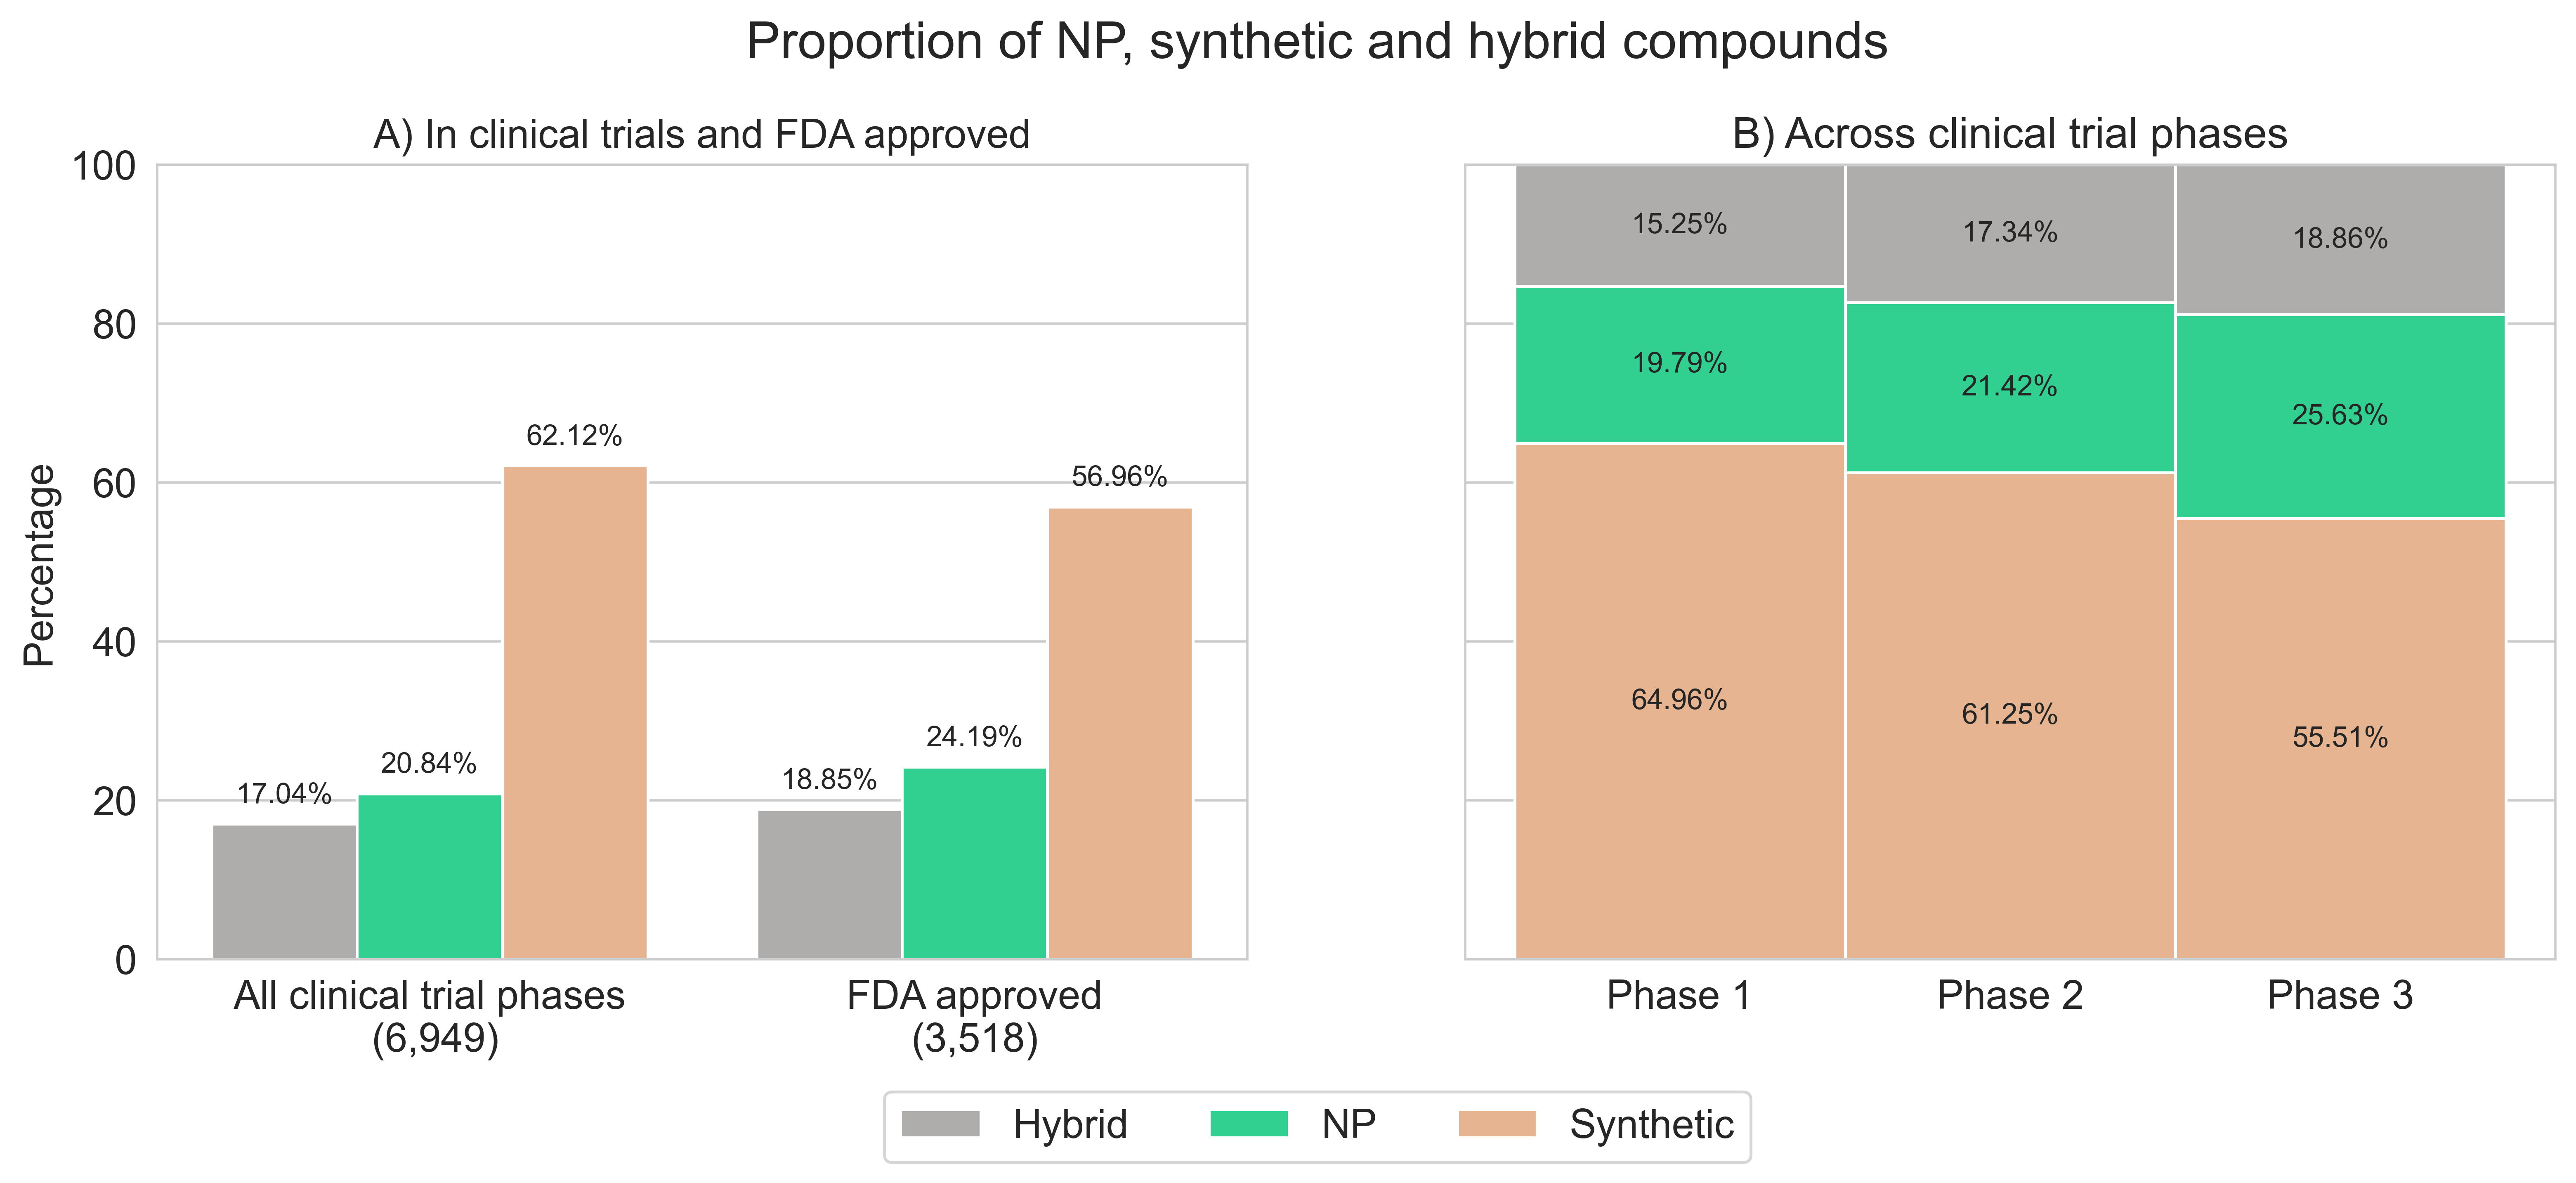

In [38]:
# 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# supertitle
fig.suptitle("Proportion of NP, synthetic and hybrid compounds", fontsize=18, y=1.02)

"""Subplot 1"""
# Subset df to the last two rows (all clinical trials and fda approved)

all_clinical_vs_fda_approved = percentages_df.tail(2).melt(
    var_name="category",
    value_name="percentage",
    ignore_index=False,
)

# drop index
all_clinical_vs_fda_approved.reset_index(drop=False, inplace=True)

sns.barplot(
    data=all_clinical_vs_fda_approved,
    x="index",
    y="percentage",
    palette=[
        "#AFABAB",
        "#16EB96",
        "#F4B183",
    ],
    hue="category",
    hue_order=["Hybrid", "NP", "Synthetic"],
    ax=ax1,
)

# add the percentage above each bar
for p in ax1.patches:
    ax1.annotate(
        f"{p.get_height():.2f}%",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
        fontsize=10,
    )

# Y axis
ax1.set_ylabel("Percentage", fontsize=14)
# rotate x axis labels
ax1.set_xlabel("", rotation=45, ha="right")

# incrase font size of x ticks
ax1.tick_params(axis="x", labelsize=14)
ax1.tick_params(axis="y", labelsize=14)

# set title
ax1.set_title("A) In clinical trials and FDA approved", fontsize=14)

# remove legend
ax1.get_legend().remove()

# set y limit
ax1.set_ylim([0, 100])

"""Subplot 2"""

# subset df to the first three rows (phase 1, 2 and 3)
phase_stratified = percentages_df.head(3).melt(
    var_name="category",
    value_name="percentage",
    ignore_index=False,
)

# drop index
phase_stratified.reset_index(drop=False, inplace=True)
# percentage type to float
phase_stratified["percentage"] = phase_stratified["percentage"].astype(float)


sns.histplot(
    data=phase_stratified,
    weights="percentage",
    x="index",
    palette=[
        "#afacac",
        "#31d091",
        "#e6b491",
    ],
    hue="category",
    hue_order=["Hybrid", "NP", "Synthetic"],
    multiple="stack",
    ax=ax2,
)

# set X ticks
ax2.set_xticks(range(3))

ax2.set_ylim([0, 100])

# remove y label
ax2.set_ylabel("")
ax2.set_xlabel("")


# remove y tick labels
ax2.set_yticklabels([])

ax2.tick_params(axis="x", labelsize=10)

ax2.set_title("B) Across clinical trial phases", fontsize=15)

# add the percentage above each bar (stacked)
for c in ax2.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else "" for v in c]

    # round labels 2 decimal places
    labels = [f"{label:.2f}%" for label in labels]

    # remove the labels parameter if it's not needed for customized labels
    ax2.bar_label(c, labels=labels, label_type="center", fontsize=10)

    # alpha 1.0
    for p in c.patches:
        p.set_alpha(1.0)
        # set saturation to 0.5
        p.set_facecolor(
            (p.get_facecolor()[0], p.get_facecolor()[1], p.get_facecolor()[2], 0.5)
        )

# x ticks labels change
ax2.set_xticklabels(
    [f"Phase {phase}" for phase in range(1, 4)], fontdict={"fontsize": 14}
)

# remove legend
ax2.get_legend().remove()

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.001),
    ncol=3,
    # increase font size
    prop={"size": 14},
)

# export 500 dpi
plt.savefig("../../data/output/plots/figure2.png", dpi=500, bbox_inches="tight")
plt.show()

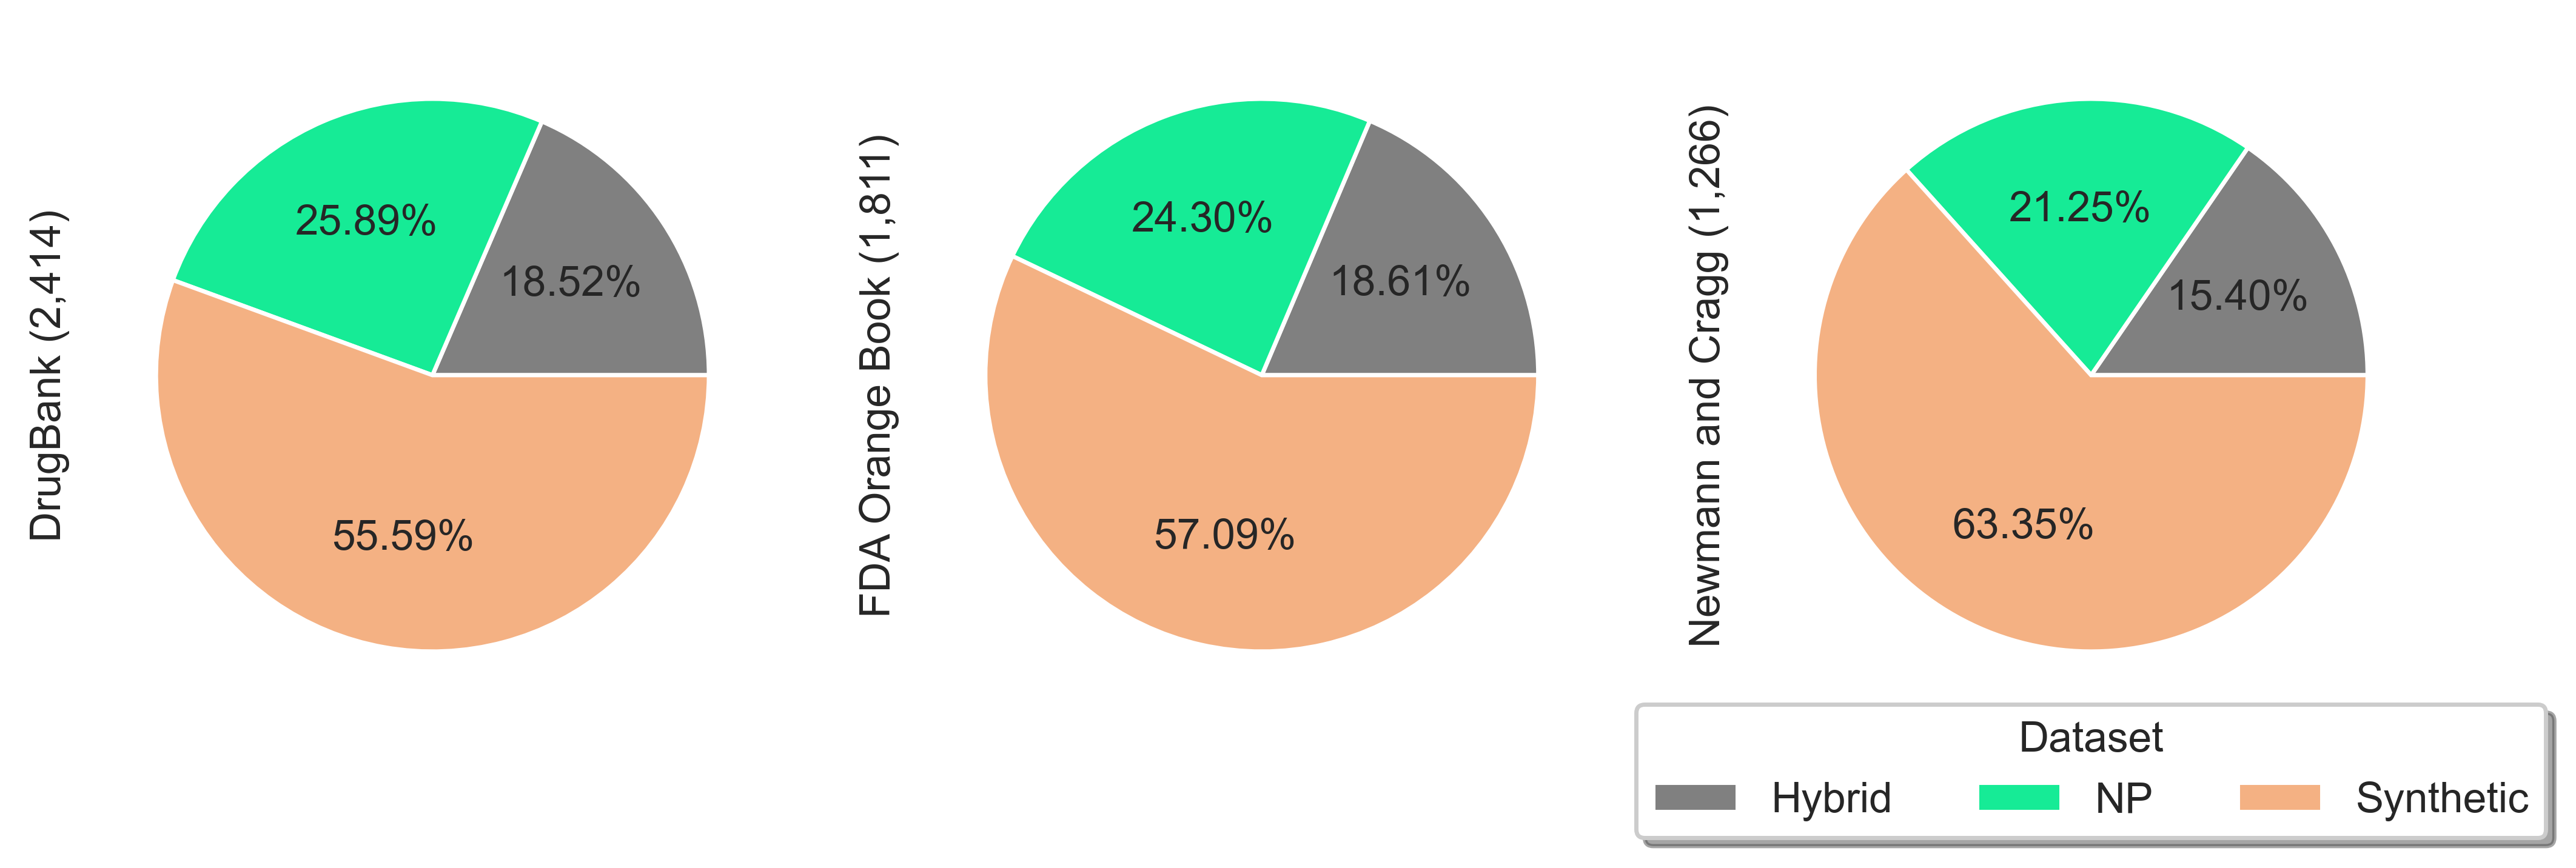

In [39]:
percentages_df.iloc[3:6:].T.plot.pie(
    subplots=True,
    # rows
    layout=(1, 3),
    figsize=(10, 8),
    colors=[
        "grey",
        "#16EB96",
        "#F4B183",
    ],
    legend=False,
    # remove names on the piechart
    labels=None,
    autopct="%.2f%%",
)


# add one single legend
plt.legend(
    percentages_df.columns,
    # loc lower center
    loc="lower center",
    # bbox_to_anchor
    bbox_to_anchor=(0.5, -0.2),
    title="Dataset",
    fancybox=True,
    shadow=True,
    ncol=3,
)

# decrease font size of the text outside the pie chart
plt.rcParams["font.size"] = 5

plt.show()

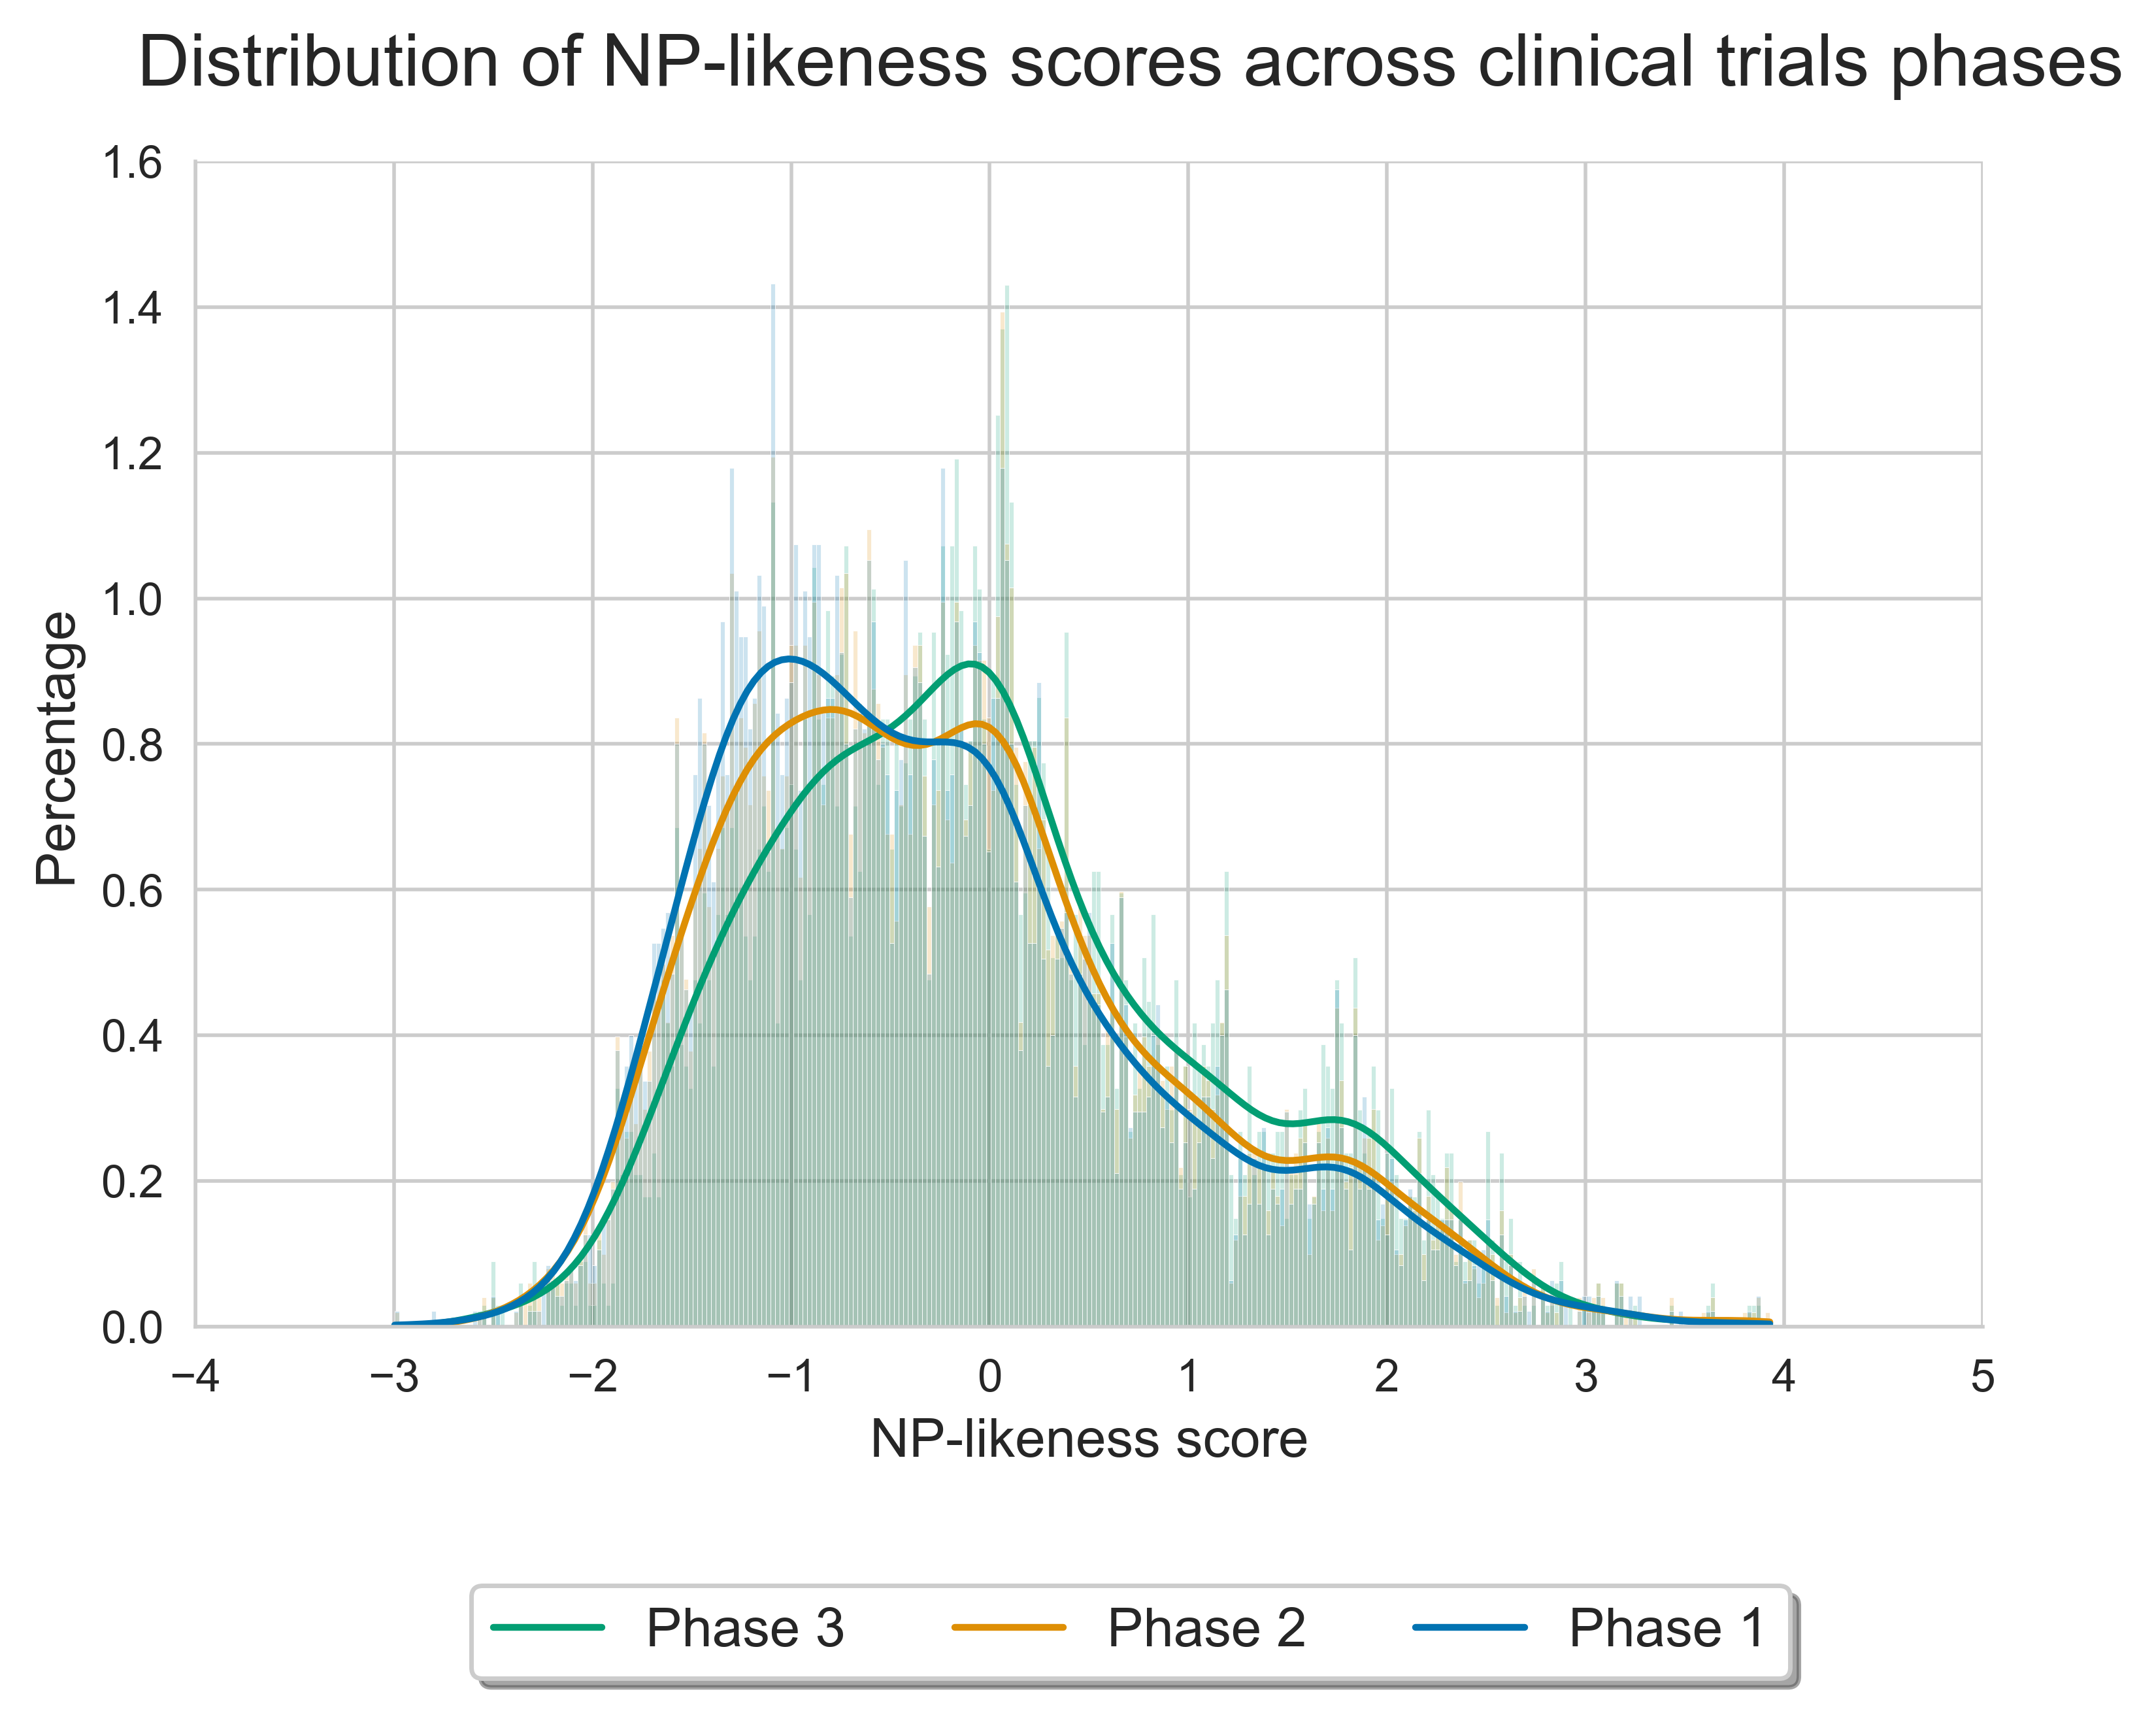

In [40]:
# Make a dataframe with the scores of phase I,II,III and their category

np_scores_df = pd.concat(
    [
        pd.DataFrame(
            {
                "score": phase_i_scores,
                "category": "Phase 1",
            }
        ),
        pd.DataFrame(
            {
                "score": phase_ii_scores,
                "category": "Phase 2",
            }
        ),
        pd.DataFrame(
            {
                "score": phase_iii_scores,
                "category": "Phase 3",
            }
        ),
    ]
)

np_scores_df.reset_index(drop=True, inplace=True)

g = sns.displot(
    data=np_scores_df,
    x="score",
    hue="category",
    stat="percent",
    kde=True,
    common_norm=False,
    fill=True,
    bins=300,
    alpha=0.20,
    height=4,
    aspect=1.5,
    palette=sns.color_palette("colorblind", 3),
)

# font size increase
g.fig.suptitle(
    "Distribution of NP-likeness scores across clinical trials phases",
    fontsize=16,
    y=1.08,
)

# Increase font size of x and y labels
g.set_axis_labels("NP-likeness score", "Percentage", fontsize=12)
# Increase font size x and y ticks
g.set_xticklabels(fontsize=10)
g.set_yticklabels(fontsize=10)

# remove legend
g._legend.remove()


g.fig.legend(
    labels=[
        "Phase 3",
        "Phase 2",
        "Phase 1",
    ],
    loc="lower center",
    bbox_to_anchor=(0.5, -0.2),
    fancybox=True,
    shadow=True,
    ncol=3,
    fontsize=12,
)

# Save figure with 500 dpi
plt.savefig(
    "../../data/output/plots/supplement_distribution_np_likeness.png",
    dpi=500,
    bbox_inches="tight",
)

plt.show()

In [41]:
# test the significance of the difference between the distributions of the three phases
from scipy.stats import ks_2samp

# Phase 1 vs Phase 2
print("Phase 1 vs Phase 2")
print(ks_2samp(phase_i_scores, phase_ii_scores))

# Phase 1 vs Phase 3
print("Phase 1 vs Phase 3")
print(ks_2samp(phase_i_scores, phase_iii_scores))

# Phase 2 vs Phase 3
print("Phase 2 vs Phase 3")
print(ks_2samp(phase_ii_scores, phase_iii_scores))

Phase 1 vs Phase 2
KstestResult(statistic=0.042087682220729006, pvalue=0.00033681775061122834, statistic_location=-0.7620161361968799, statistic_sign=1)
Phase 1 vs Phase 3
KstestResult(statistic=0.11445129531064943, pvalue=6.896689707990307e-23, statistic_location=-0.5434562916264819, statistic_sign=1)
Phase 2 vs Phase 3
KstestResult(statistic=0.07842143171655672, pvalue=3.266681247411487e-11, statistic_location=-0.5463070549699028, statistic_sign=1)


In [42]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# perform ANOVA test
data = np_scores_df[["score", "category"]]
result_anova = f_oneway(
    data[data["category"] == "Phase 1"]["score"],
    data[data["category"] == "Phase 2"]["score"],
    data[data["category"] == "Phase 3"]["score"],
)

# Check ANOVA p-value
print("ANOVA p-value:", result_anova.pvalue)

print("\n")

# perform Tukey's test
tukey = pairwise_tukeyhsd(endog=data["score"], groups=data["category"], alpha=0.05)

# display results
print(tukey)

ANOVA p-value: 2.9558756723467985e-22


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj  lower  upper  reject
----------------------------------------------------
Phase 1 Phase 2   0.0788 0.0011 0.0268 0.1308   True
Phase 1 Phase 3   0.2449    0.0 0.1869 0.3028   True
Phase 2 Phase 3    0.166    0.0 0.1088 0.2233   True
----------------------------------------------------


## NPClassifier

In [43]:
def export_np_classifier_summary(
    drugbank_np_classifier,
    fda_orange_book_np_classifier,
    phase_i_np_classifier,
    phase_ii_np_classifier,
    phase_iii_np_classifier,
    all_approved_drugs_np_classifier,
    level,
):
    # All keys in the superclass dict
    level_classes = set(
        list(drugbank_np_classifier[level].keys())
        + list(fda_orange_book_np_classifier[level].keys())
        + list(phase_i_np_classifier[level].keys())
        + list(phase_ii_np_classifier[level].keys())
        + list(phase_iii_np_classifier[level].keys())
        + list(all_approved_drugs_np_classifier[level].keys())
    )

    # Make a df where the index are the superclass and there are two columns for each of the datasets
    df = pd.DataFrame(
        index=sorted(list(level_classes)),
        columns=[
            "phase_1",
            "phase_2",
            "phase_3",
            "fda_orange_book",
            "drugbank",
            "all_approved",
        ],
    )

    # Fill the dataframe
    for np_class in level_classes:
        df.loc[np_class, "phase_1"] = len(
            phase_i_np_classifier[level].get(np_class, [])
        )

        df.loc[np_class, "phase_2"] = len(
            phase_ii_np_classifier[level].get(np_class, [])
        )

        df.loc[np_class, "phase_3"] = len(
            phase_iii_np_classifier[level].get(np_class, [])
        )

        df.loc[np_class, "fda_orange_book"] = len(
            fda_orange_book_np_classifier[level].get(np_class, [])
        )
        df.loc[np_class, "drugbank"] = len(
            drugbank_np_classifier[level].get(np_class, [])
        )

        df.loc[np_class, "all_approved"] = len(
            all_approved_drugs_np_classifier[level].get(np_class, [])
        )

    df.sort_values(by="all_approved", ascending=False, inplace=True)

    for column in df.columns:
        try:
            df[column] = df[column] / df[column].sum()
        except ZeroDivisionError:
            continue

        df[column] = df[column].apply(lambda x: round(x * 100, 2))

    try:
        df["approved / phase 1 ratio"] = (df["all_approved"] / df["phase_1"]).apply(
            lambda x: round(x, 2)
        )
    except ZeroDivisionError:
        df["approved / phase 1 ratio"] = ""

    # sort by the ratio
    df.sort_values(by="approved / phase 1 ratio", ascending=False, inplace=True)

    df.to_csv(f"../../data/output/{level}_np_classifier_approved.tsv", sep="\t")

In [44]:
export_np_classifier_summary(
    drugbank_np_classifier=drugbank_np_classifier,
    fda_orange_book_np_classifier=fda_orange_book_np_classifier,
    phase_i_np_classifier=phase_i_np_classifier,
    phase_ii_np_classifier=phase_ii_np_classifier,
    phase_iii_np_classifier=phase_iii_np_classifier,
    all_approved_drugs_np_classifier=all_approved_drugs_np_classifier,
    level="superclass",
)

export_np_classifier_summary(
    drugbank_np_classifier=drugbank_np_classifier,
    fda_orange_book_np_classifier=fda_orange_book_np_classifier,
    phase_i_np_classifier=phase_i_np_classifier,
    phase_ii_np_classifier=phase_ii_np_classifier,
    phase_iii_np_classifier=phase_iii_np_classifier,
    all_approved_drugs_np_classifier=all_approved_drugs_np_classifier,
    level="pathway",
)